In [1]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
from random import random, seed
import sys
sys.path.append("../")
import functions as f
plt.style.use('seaborn-v0_8-whitegrid')
#plt.style.available
import seaborn as sns
import load_data as ld
import classes as cl
from sklearn import datasets
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

## Own code regression

In [2]:
# Load data for regression
X, y, x, a_true = ld.load_simple_data(N_samples=200, noise=0.5)

# Reshape target variable
y = y.reshape(-1, 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Standardize the data
X_train, X_test = f.scale_train_test(X_train, X_test)
y_train, y_test = f.scale_train_test(y_train, y_test)

# Set layer sizes: 3 (input), 12 (hidden), 12 (hidden), 1 (output)
input_size = X_train.shape[1]  # 3 input features (ones, x, x**2)
layer_sizes = [12, 12, 1]

# Sigmoid for hidden layers, Linear for the output layer
activation_funcs = [f.sigmoid, f.sigmoid, f.linear]

# Define learning rates and epochs to test
learning_rates = [0.00001, 0.0001, 0.001, 0.01, 0.1]
epochs_list = [900, 925, 950, 975, 1000]

# Initialize arrays to store MSE and R^2 values
mse_array = np.zeros((len(learning_rates), len(epochs_list)))
r2_array = np.zeros((len(learning_rates), len(epochs_list)))

for j, epoch in enumerate(epochs_list):
    for i, lr in enumerate(learning_rates):
        
        # Initialize layers and activation functions
        layers = f.create_layers_batch(input_size, layer_sizes)
        
        # Train the neural network
        trained_layers = f.train_network(X_train, y_train, layers, activation_funcs, f.cost_mse, lr, epoch)
        
        # Predict on test data
        y_pred = f.feed_forward_batch(X_test, trained_layers, activation_funcs)
        
        # Calculate performance metrics
        mse_value = f.mse(y_test, y_pred)
        r2_value = f.r2(y_test, y_pred)
        
        # Store the results
        mse_array[i, j] = mse_value
        r2_array[i, j] = r2_value

# Output results
print(f"MSE: {mse_value:.4f}")
print(f"R^2: {r2_value:.4f}")

Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Epoch 0: Layer shapes:
Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: W shape = (12, 12), b shape = (12,)
Layer 2: W shape = (1, 12), b shape = (1,)
Layer 0: W shape = (12, 3), b shape = (12,)
Layer 1: 

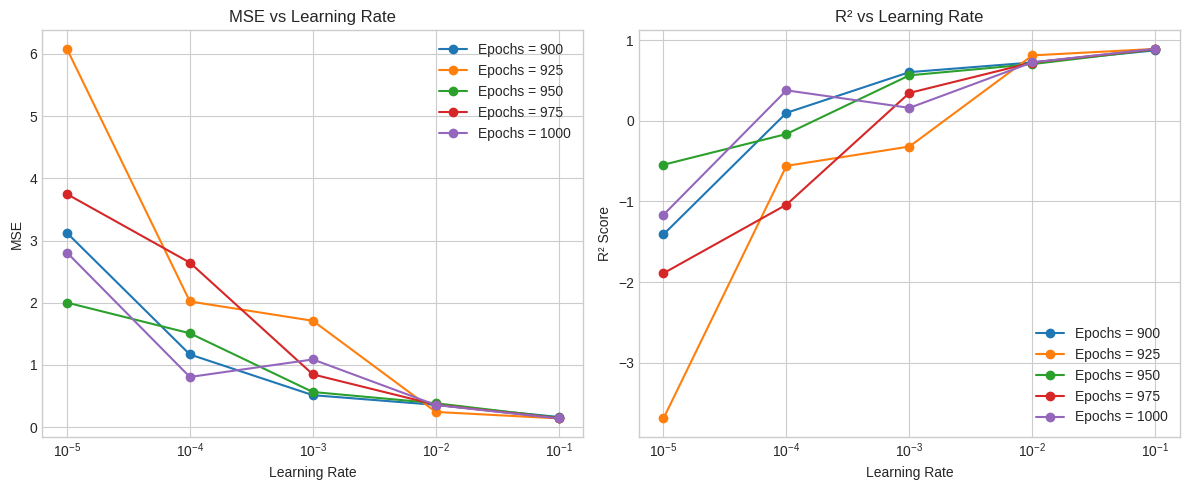

In [3]:
# Plot the results
f.plot_mse_and_r2(mse_array, r2_array, learning_rates, epochs_list)

#f.plot_metric_vs_learning_rate(learning_rate, mse_list, 'MSE', 'MSE (linear scale)', 'MSE vs Learning Rate')
#f.plot_metric_vs_learning_rate(learning_rate, r2_list, 'R2', 'R2 (linear scale)', 'R2 vs Learning Rate')

## Keras code regression

In [4]:
import torch
import torch.nn as nn
import torch.optim as optim


# Load data for regression
X, y, _, _ = ld.load_simple_data(N_samples=200, noise=0.5)

# Reshape target variable
y = y.reshape(-1, 1)

# Split the dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# Standardize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert data to torch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.float32)

# Set model parameters
input_size = X_train.shape[1]
hidden_size1 = 12
hidden_size2 = 12
output_size = 1

learning_rate = [0.00001, 0.0001, 0.001, 0.01, 0.1]
epochs_list = [900, 925, 950, 975, 1000]

# Initialize arrays to store MSE and R^2 values
mse_array = np.zeros((len(learning_rate), len(epochs_list)))
r2_array = np.zeros((len(learning_rate), len(epochs_list)))

for j, epoch in enumerate(epochs_list):
    for i, lr in enumerate(learning_rates):
        # Initialize the model, loss function, and optimizer
        model = cl.RegClasNN(input_size, hidden_size1, hidden_size2, output_size, activation_function = nn.Sigmoid(), last_layer_activation = f.linear)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=lr)

        # Train the model
        for epoch_idx in range(epoch):
            model.train()
            outputs = model(X_train)
            loss = criterion(outputs, y_train)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Optional: Print loss every 100 epochs
            # if (epoch_idx+1) % 100 == 0:
            #     print(f'Epoch [{epoch_idx+1}/{epoch}], Loss: {loss.item():.4f}')

        # Evaluate the model
        model.eval()
        with torch.no_grad():
            y_pred = model(X_test)

        # Convert PyTorch tensors to NumPy arrays for metric calculation
        y_test_np = y_test.detach().numpy()
        y_pred_np = y_pred.detach().numpy()

        # Calculate performance metrics
        mse_value = f.mse(y_test_np, y_pred_np)
        r2_value = f.r2(y_test_np, y_pred_np)

        # Store the results
        mse_array[i, j] = mse_value
        r2_array[i, j] = r2_value

    # Output results
    print(f"MSE: {mse_value:.4f}")
    print(f"R^2: {r2_value:.4f}")



MSE: 0.3440
R^2: 0.8811
MSE: 0.3200
R^2: 0.8894
MSE: 0.3585
R^2: 0.8761
MSE: 0.3116
R^2: 0.8924
MSE: 0.3264
R^2: 0.8872


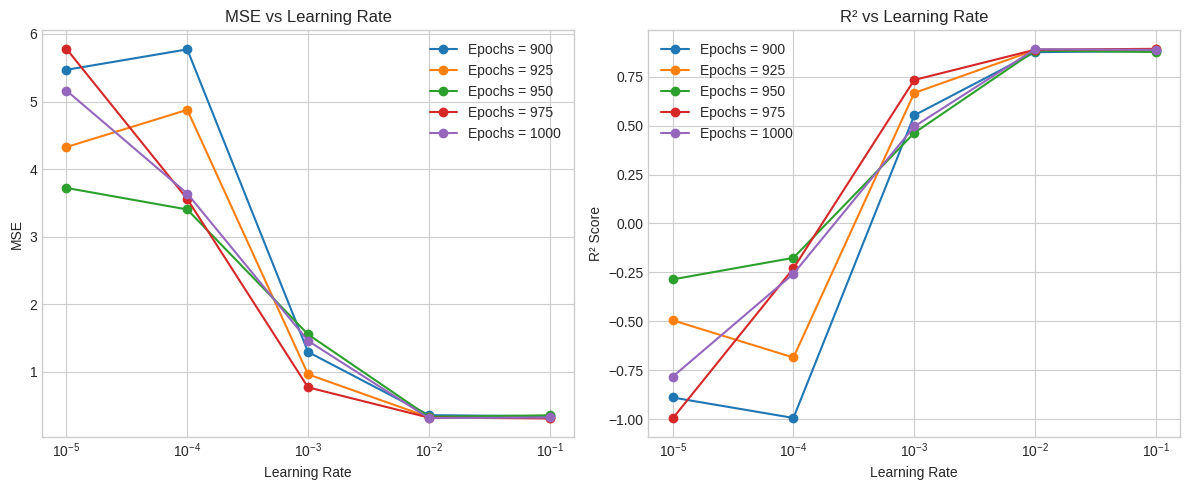

In [5]:
f.plot_mse_and_r2(mse_array, r2_array, learning_rates, epochs_list)
